In [6]:
import torch
from datasets.mnist import MNIST
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torchvision
import os

from nn.enforced_ae import EnforcedAE
from train import train
from schedule import cosine_schedule


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   


In [2]:
train_dataset = MNIST(root='../../datasets', split='train', download=False, device=device, normalize=False, augment=True)
val_dataset = MNIST(root='../../datasets', split='val', download=False, device=device, normalize=False)
test_dataset = MNIST(root='../../datasets', split='test', download=False, device=device, normalize=False)

In [8]:
experiment_name = 'base'
trial_name = 'base_cnn20_schedules'

model = EnforcedAE(in_channels=1, z_dim=20, cnn=True).to(device)
optimiser = torch.optim.AdamW(model.parameters(), lr=1e-3)
num_epochs = 200
batch_size = 256
compute_dtype = torch.bfloat16

hyperparams = {
    'lr': cosine_schedule(base=1e-3, end=1e-4, T=num_epochs, warmup=10, flat_end=10),
    'wd': cosine_schedule(base=0.004, end=0.1, T=num_epochs)
}

trial_log_dir = f'out/logs/{experiment_name}/{trial_name}'
run_no = 0
while os.path.exists(trial_log_dir + f'/run_{run_no}'):
    run_no += 1
writer = SummaryWriter(trial_log_dir + f'/run_{run_no}')
save_dir = f'out/models/{experiment_name}/{trial_name}/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_dir=save_dir + f'run_{run_no}.pt'


train(model, train_dataset, val_dataset, optimiser, num_epochs=num_epochs, batch_size=batch_size, writer=writer, compute_dtype=compute_dtype, save_dir=save_dir, epoch_hyperparams=hyperparams)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

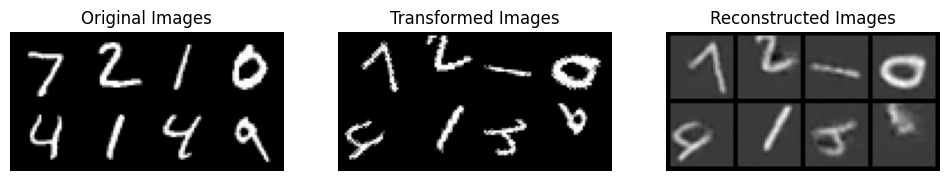

In [9]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

images, _= next(iter(test_loader))
images_aug, actions = model.interact(images)
images_hat = model(images, actions)[0]

import matplotlib.pyplot as plt

# Plot original images
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(torchvision.utils.make_grid(images.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[0].set_title('Original Images')
axes[0].axis('off')

axes[1].imshow(torchvision.utils.make_grid(images_aug.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[1].set_title('Transformed Images')
axes[1].axis('off')

axes[2].imshow(torchvision.utils.make_grid(images_hat.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
axes[2].set_title('Reconstructed Images')
axes[2].axis('off')

plt.show()


In [16]:
from ipywidgets import interact, FloatSlider
import pandas as pd
import numpy as np

def plot_images_with_widgets(model, images):
    def update(a0=0., a1=0., a2=0., a3=0., a4=0.):
        actions = torch.tensor([a0, a1, a2, a3, a4])
        images_aug, _ = model.transform_images(images, actions)
        x_hat, z = model.forward(images, actions)

        fig, axes = plt.subplots(1, 3, figsize=(12, 6))
        axes[0].imshow(torchvision.utils.make_grid(images.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
        axes[0].set_title('Original Images')
        axes[0].axis('off')

        axes[1].imshow(torchvision.utils.make_grid(images_aug.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
        axes[1].set_title('Transformed Images')
        axes[1].axis('off')

        axes[2].imshow(torchvision.utils.make_grid(x_hat.cpu(), nrow=4, padding=2, normalize=True).permute(1, 2, 0))
        axes[2].set_title('Reconstructed Images')
        axes[2].axis('off')

        plt.show()

        # Print table of modified z values
        df = pd.DataFrame(np.round(z.cpu().detach().numpy(), 3), columns=[f'z_{i}' for i in range(10)])
        print(df)

    interact(update, 
             a0=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             a1=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             a2=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             a3=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.),
             a4=FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.))

images = test_dataset[0:8][0]
plot_images_with_widgets(model, images)

interactive(children=(FloatSlider(value=0.0, description='a0', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

In [11]:
from ipywidgets import interact, FloatSlider
import pandas as pd

def plot_images_with_widgets(model):
    idx = torch.randint(0, len(test_dataset), (1,))
    image = test_dataset[idx][0]
    z = model.infer(image)
    def update(z0=0., z1=0., z2=0., z3=0., z4=0., z5=0., z6=0., z7=0., z8=0., z9=0.):
        z[:, :10] = torch.tensor([z0, z1, z2, z3, z4, z5, z6, z7, z8, z9])
        x_hat = model.decode(z).detach()
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(image.cpu().squeeze(0).permute(1, 2, 0), cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(x_hat.cpu().squeeze(0).permute(1, 2, 0), cmap='gray')
        axes[1].set_title('Reconstructed Image')
        axes[1].axis('off')

        plt.show()

        # Print table of modified z values
        df = pd.DataFrame(np.round(z[:,:10].cpu().detach().numpy(), 3), columns=[f'z_{i}' for i in range(10)])
        print(df)

    interact(update, 
             z0=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,0].item()),
             z1=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,1].item()),
             z2=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,2].item()),
             z3=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,3].item()),
             z4=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,4].item()),
             z5=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,5].item()),
             z6=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,6].item()),
             z7=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,7].item()),
             z8=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,8].item()),
             z9=FloatSlider(min=-3.0, max=3.0, step=0.1, value=z[:,9].item()))

plot_images_with_widgets(model)

interactive(children=(FloatSlider(value=-0.015894096344709396, description='z0', max=3.0, min=-3.0), FloatSlid…